In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from tqdm.notebook import tqdm
import requests
import datetime
import time
from collections import Counter
from random import uniform, randint
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from natasha import (Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger,
                     NewsNERTagger, Doc)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             f1_score, classification_report)

import gc
import torch
import torchtext
import torch.nn as nn
from torch.optim import Adam
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
device = torch.device('cuda')

# Setup

## Data

In [10]:
additional_stopwords = [
    'которых', 'которые', 'твой', 'которой', 'которого', 'сих', 'ком', 'свой',
    'твоя', 'этими', 'слишком', 'нами', 'всему', 'будь', 'саму', 'чаще',
    'ваше', 'сами', 'наш', 'затем', 'самих', 'наши', 'ту', 'каждое', 'мочь',
    'весь', 'этим', 'наша', 'своих', 'оба', 'который', 'зато', 'те', 'этих',
    'вся', 'ваш', 'такая', 'теми', 'ею', 'которая', 'нередко', 'каждая',
    'также', 'чему', 'собой', 'самими', 'нем', 'вами', 'ими', 'откуда',
    'такие', 'тому', 'та', 'очень', 'сама', 'нему', 'алло', 'оно', 'этому',
    'кому', 'тобой', 'таки', 'твоё', 'каждые', 'твои', 'нею', 'самим', 'ваши',
    'ваша', 'кем', 'мои', 'однако', 'сразу', 'свое', 'ними', 'всё', 'неё',
    'тех', 'хотя', 'всем', 'тобою', 'тебе', 'одной', 'другие', 'само', 'эта',
    'самой', 'моё', 'своей', 'такое', 'всею', 'будут', 'своего', 'кого',
    'свои', 'мог', 'нам', 'особенно', 'её', 'самому', 'наше', 'кроме',
    'вообще', 'вон', 'мною', 'никто', 'это'
]

stop_words = stopwords.words('russian') + additional_stopwords

In [11]:
# Natasha <3
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

ner_tagger = NewsNERTagger(emb)

In [12]:
del_n = re.compile('\n')
del_tags = re.compile('<[^>]*>')
del_brackets = re.compile('\([^)]*\)')
clean_text = re.compile('[^а-яa-z\s]')
del_spaces = re.compile('\s{2,}')


def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ', res_text)


def del_stopwords(text):
    clean_tokens = tuple(
        map(lambda x: x if x not in stop_words else '', word_tokenize(text)))
    res_text = ' '.join(clean_tokens)
    return res_text


def lemmatize(text):
    text = Doc(text)
    text.segment(segmenter)
    text.tag_morph(morph_tagger)
    for token in text.tokens:
        token.lemmatize(morph_vocab)
    text.tag_ner(ner_tagger)
    for span in text.spans:
        span.normalize(morph_vocab)
    return ' '.join([token.lemma for token in text.tokens])

In [13]:
def preprocess_and_save(df, save_name):
    txt_lst = []
    txts = df.body.copy()

    for text in tqdm(txts):
        text = prepare_text(text)
        text = del_stopwords(text)
        text = lemmatize(text)
        txt_lst.append(text)
    
    # Save locally file with preprocessed texts (for convenience)
    df_safe = pd.concat(
        [df, pd.DataFrame(txt_lst, columns=['text_clear'])], axis=1)

    df_safe.to_parquet(f'../Data/Final/{save_name}_final_5years.parquet', index=False)

In [14]:
def define_classes(df, main_col, class_col, p=0.05):
    df_ret = df.copy()

    q_l = df_ret[main_col].quantile(p)
    q_u = df_ret[main_col].quantile(1 - p)

    df_ret[class_col] = 1
    df_ret.loc[df_ret[main_col] <= q_l, class_col] = 0
    df_ret.loc[df_ret[main_col] >= q_u, class_col] = 2

    print(df_ret[class_col].value_counts())
    
    return df_ret

## Models

In [15]:
def plot_losses(train_losses, test_metrics):
    clear_output()
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(test_metrics) + 1), test_metrics, label='test', color='springgreen', linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
def plot_metric(train_metrics, test_metrics):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_metrics) + 1), train_metrics, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(test_metrics) + 1), test_metrics, label='test', color='springgreen', linewidth=2)
    plt.ylabel('f1_macro')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [16]:
def create_dataset(X, y):
    data = []
    for i in range(X.shape[0]):
        data.append((y.values[i], X.values[i]))
    return data


def tokenizer(text):
    return text.split(' ')


def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)


def vectorize_batch(batch):
    global vocab, MAX_LEN
    
    Y, X = list(zip(*batch))
    # Tokenize and map tokens to indexes
    X = [vocab(tokenizer(text)) for text in X]
    # Bringing all samples to max_words length
    X = [
        tokens + ([0] * (MAX_LEN - len(tokens)))
        if len(tokens) < MAX_LEN else tokens[:MAX_LEN] for tokens in X
    ]

    return torch.tensor(
        X, dtype=torch.int32).to(device), torch.tensor(Y).to(device)

In [17]:
def init_data_and_vocab(texts, labels, min_freq):
    X_train, X_test, y_train, y_test = train_test_split(texts,
                                                        labels,
                                                        random_state=42,
                                                        test_size=0.25,
                                                        stratify=labels)

    X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                      y_train,
                                                      random_state=42,
                                                      test_size=0.25,
                                                      stratify=y_train)

    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_train),
                                         y=y_train)

    train_dataset = create_dataset(X_train, y_train)
    val_dataset = create_dataset(X_val, y_val)
    test_dataset = create_dataset(X_test, y_test)

    vocab = build_vocab_from_iterator(build_vocabulary(
        [train_dataset, val_dataset, test_dataset]),
                                      min_freq=min_freq,
                                      specials=["<UNK>"])
    vocab.set_default_index(vocab["<UNK>"])

    print(f'Vocabulary size: {len(vocab)}')

    return train_dataset, val_dataset, test_dataset, vocab, class_weights


def init_loaders(train, val, test, batch_size):
    train = to_map_style_dataset(train)
    val = to_map_style_dataset(val)
    test = to_map_style_dataset(test)

    target_classes = [0, 1, 2]

    train_loader = DataLoader(train,
                              batch_size=batch_size,
                              collate_fn=vectorize_batch,
                              shuffle=True)
    val_loader = DataLoader(val,
                            batch_size=batch_size,
                            collate_fn=vectorize_batch)
    test_loader = DataLoader(test,
                             batch_size=batch_size,
                             collate_fn=vectorize_batch)

    return train_loader, val_loader, test_loader

In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, vocab):
        super(LSTMClassifier, self).__init__()

        self.vocab = vocab
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding_layer = nn.Embedding(num_embeddings=len(self.vocab),
                                            embedding_dim=self.emb_dim)

        self.lstm = nn.LSTM(input_size=self.emb_dim,
                            hidden_size=self.hid_dim,
                            num_layers=self.n_layers,
                            batch_first=True)

        self.linear = nn.Linear(self.hid_dim, 3)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden, carry = torch.zeros(self.n_layers,
                                    len(X_batch),
                                    self.hid_dim,
                                    device=device), torch.zeros(self.n_layers,
                                                                len(X_batch),
                                                                self.hid_dim,
                                                                device=device)
        output, (hidden, carry) = self.lstm(embeddings, (hidden, carry))
        return self.linear(output[:, -1])


def evaluate(model, loss_fn, val_loader):
    model.eval()
    Y_shuffled, Y_preds, losses = [], [], []

    for X, Y in val_loader:
        with torch.no_grad():

            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds = torch.cat(Y_preds)

    avg_loss = torch.tensor(losses).mean()
    f1_macro = f1_score(Y_shuffled.detach().cpu().numpy(),
                        Y_preds.detach().cpu().numpy(),
                        average='macro')

    return avg_loss, f1_macro, Y_preds, Y_shuffled


def train(model, loss_fn, optimizer, train_loader):
    model.train()
    Y_shuffled, Y_preds_l, losses = [], [], []
    for X, Y in train_loader:

        model.zero_grad()
        Y_preds = model(X)
        loss = loss_fn(Y_preds, Y)
        losses.append(loss.item())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        Y_shuffled.append(Y)
        Y_preds_l.append(Y_preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds_l = torch.cat(Y_preds_l)

    avg_loss = torch.tensor(losses).mean()
    f1_macro = f1_score(Y_shuffled.detach().cpu().numpy(),
                        Y_preds_l.detach().cpu().numpy(),
                        average='macro')

    return avg_loss, f1_macro

In [19]:
def rock_and_roll(model, loss_fn, optimer, train_loader, test_loader,
                  path_artifacts):
    best_test_metric = float('-inf')

    train_losses = []
    test_losses = []

    train_metrics = []
    test_metrics = []

    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_metric = train(model, loss_fn, optimizer,
                                         train_loader)
        test_loss, test_metric, _, _ = evaluate(model, loss_fn, test_loader)

        if test_metric > best_test_metric:
            best_test_metric = test_metric
            torch.save(model, path_artifacts)

        train_losses.append(train_loss)
        train_metrics.append(train_metric)

        test_losses.append(test_loss)
        test_metrics.append(test_metric)

    plot_losses(train_losses, test_losses)
    plot_metric(train_metrics, test_metrics)

    torch.cuda.empty_cache()


def check_model(path_artifacts, loss_fn, test_loader):
    best_model = torch.load(path_artifacts)
    _, metric, pred_y, true_y = evaluate(best_model, loss_fn, test_loader)

    pred_y = pred_y.detach().cpu().numpy()
    true_y = true_y.detach().cpu().numpy()

    print(classification_report(true_y, pred_y))

# Model for the companies

In [2]:
df_comp = pd.read_parquet('../Data/MOEX/comp_data_after_moex_5years.parquet')

## Preprocessing

In [13]:
preprocess_and_save(df_comp, 'comp')

In [13]:
df_comp = pd.read_parquet('../Data/Final/comp_final_5years.parquet')

for i, text in enumerate(df_comp.text_clear):
    df_comp.loc[i, 'text_clear'] = prepare_text(text).strip()

In [14]:
df_comp = define_classes(df_comp, 'price_diff_percent', 'price_diff_cat', 0.05)

price_diff_cat
1    45261
2     2515
0     2515
Name: count, dtype: int64


## Model

In [38]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 50  # number of epochs
LR = 5e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/comp/comp_model.h5'
PATH_VOCABS = 'vocabs/comp_vocab.pt'

# Datasets
train_dataset, val_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_comp['text_clear'], labels=df_comp['price_diff_cat'], min_freq=30)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, val_loader, test_loader = init_loaders(train_dataset, val_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 12448
Saved vocab size: 12448


In [42]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(12448, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 6292451

class_weights=array([6.66855257, 0.37037328, 6.66383981])


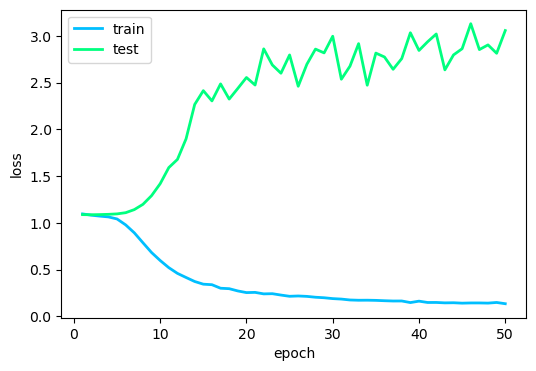

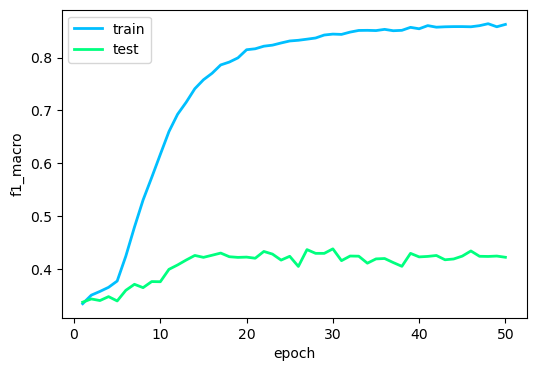

              precision    recall  f1-score   support

           0       0.17      0.18      0.17       629
           1       0.92      0.92      0.92     11315
           2       0.18      0.15      0.16       629

    accuracy                           0.84     12573
   macro avg       0.42      0.42      0.42     12573
weighted avg       0.84      0.84      0.84     12573

CPU times: total: 3min 50s
Wall time: 14min 25s


In [43]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=val_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)

# Model for the industries

In [67]:
df_ind = pd.read_parquet('../Data/MOEX/ind_data_after_moex_5years.parquet')

## Preprocessing

In [14]:
preprocess_and_save(df_ind, 'ind')

In [44]:
df_ind = pd.read_parquet('../Data/Final/ind_final_5years.parquet')

for i, text in enumerate(df_ind.text_clear):
    df_ind.loc[i, 'text_clear'] = prepare_text(text).strip()

In [45]:
df_ind = define_classes(df_ind, 'price_diff_percent', 'price_diff_cat', 0.05)

price_diff_cat
1    32255
2     1792
0     1792
Name: count, dtype: int64


## Model 

In [58]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 30  # number of epochs
LR = 5e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/ind/ind_model.h5'
PATH_VOCABS = 'vocabs/ind_vocab.pt'

# Datasets
train_dataset, val_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_ind['text_clear'], labels=df_ind['price_diff_cat'], min_freq=30)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, val_loader, test_loader = init_loaders(train_dataset, val_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 9967
Saved vocab size: 9967


In [59]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(9967, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 5051951

class_weights=array([6.66633598, 0.37037241, 6.66633598])


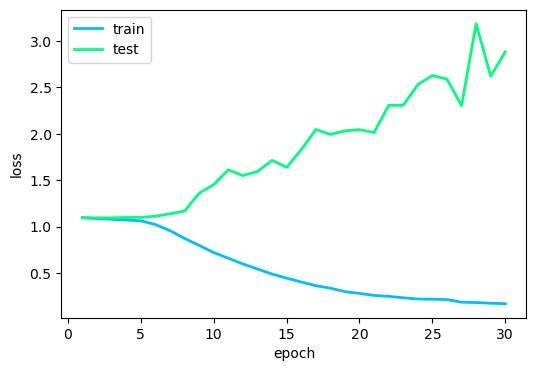

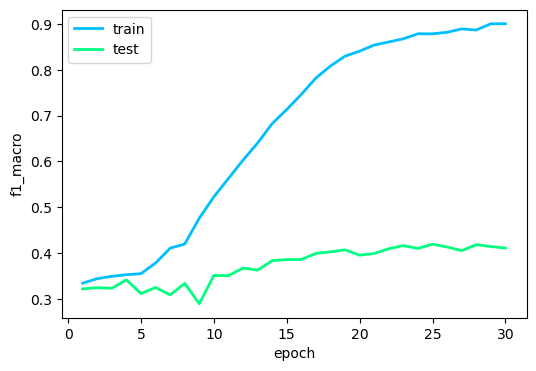

              precision    recall  f1-score   support

           0       0.19      0.14      0.16       448
           1       0.91      0.90      0.91      8064
           2       0.09      0.13      0.10       448

    accuracy                           0.82      8960
   macro avg       0.40      0.39      0.39      8960
weighted avg       0.83      0.82      0.83      8960

CPU times: total: 1min 41s
Wall time: 5min 51s


In [57]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=val_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)

# Model for the global

In [10]:
df_glob = pd.read_parquet('../Data/MOEX/glob_data_after_moex_5years.parquet')

## Preprocessing

In [15]:
preprocess_and_save(df_glob, 'glob')

In [20]:
df_glob = pd.read_parquet('../Data/Final/glob_final_5years.parquet')

for i, text in enumerate(df_glob.text_clear):
    df_glob.loc[i, 'text_clear'] = prepare_text(text).strip()

In [21]:
df_glob = define_classes(df_glob, 'imoex_price_diff_percent', 'imoex_price_diff_cat', 0.05)
df_glob = define_classes(df_glob, 'rvi_price_diff_percent', 'rvi_price_diff_cat', 0.05)
df_glob = define_classes(df_glob, 'usd_price_diff_percent', 'usd_price_diff_cat', 0.05)

imoex_price_diff_cat
1    76851
2     3835
0     3835
Name: count, dtype: int64
rvi_price_diff_cat
1    76281
0     4120
2     4120
Name: count, dtype: int64
usd_price_diff_cat
1    76549
0     3986
2     3986
Name: count, dtype: int64


## Models 

### Model MOEX

In [22]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 40  # number of epochs
LR = 5e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/glob/glob_moex_model.h5'
PATH_VOCABS = 'vocabs/glob_moex_vocab.pt'

# Datasets
df_glob_imoex = df_glob.dropna(subset=['imoex_price_diff_percent']).reset_index(drop=True).copy()
train_dataset, val_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_glob_imoex['text_clear'], labels=df_glob_imoex['imoex_price_diff_cat'], min_freq=30)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, val_loader, test_loader = init_loaders(train_dataset, val_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 14152
Saved vocab size: 14152


In [23]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(14152, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 7144451

class_weights=array([6.66697574, 0.37036846, 6.66697574])


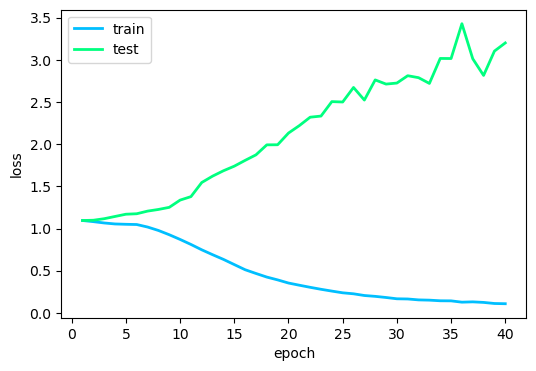

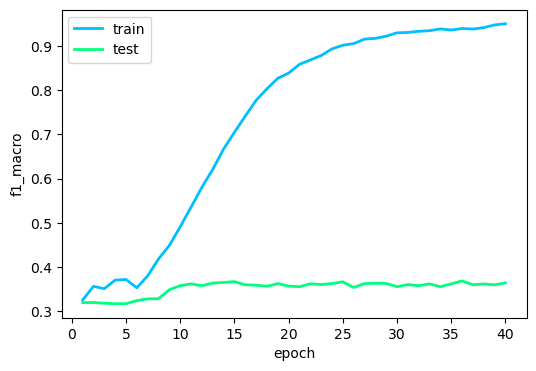

              precision    recall  f1-score   support

           0       0.12      0.12      0.12       959
           1       0.91      0.91      0.91     17257
           2       0.11      0.09      0.10       959

    accuracy                           0.83     19175
   macro avg       0.38      0.38      0.38     19175
weighted avg       0.83      0.83      0.83     19175

CPU times: total: 7min 10s
Wall time: 16min 46s


In [24]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=val_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)

### Model RVI

In [60]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 40  # number of epochs
LR = 4e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/glob/glob_rvi_model.h5'
PATH_VOCABS = 'vocabs/glob_rvi_vocab.pt'

# Datasets
df_glob_rvi = df_glob.dropna(subset=['rvi_price_diff_percent']).reset_index(drop=True).copy()
train_dataset, val_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_glob_rvi['text_clear'], labels=df_glob_rvi['rvi_price_diff_cat'], min_freq=30)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, val_loader, test_loader = init_loaders(train_dataset, val_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 14772
Saved vocab size: 14772


In [61]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(14772, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 7454451

class_weights=array([6.66681053, 0.37037836, 6.66393443])


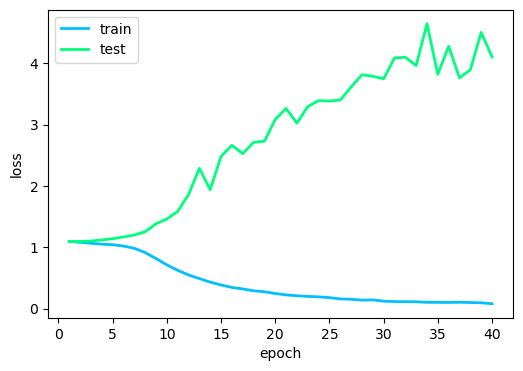

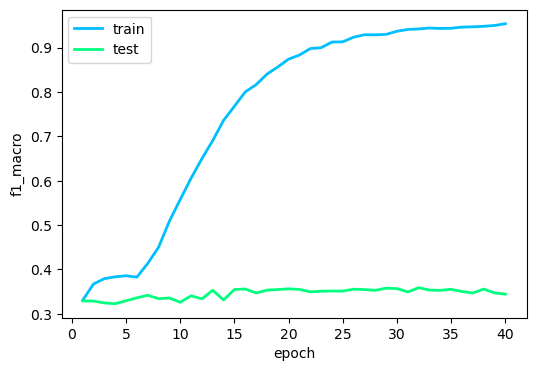

              precision    recall  f1-score   support

           0       0.09      0.06      0.07      1030
           1       0.90      0.94      0.92     18537
           2       0.08      0.06      0.07      1030

    accuracy                           0.85     20597
   macro avg       0.36      0.35      0.35     20597
weighted avg       0.82      0.85      0.83     20597

CPU times: total: 6min 37s
Wall time: 18min 40s


In [62]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=val_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)

### Model RUBUSD

In [44]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 40  # number of epochs
LR = 5e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/glob/glob_rubusd_model.h5'
PATH_VOCABS = 'vocabs/glob_rubusd_vocab.pt'

# Datasets
df_glob_rubusd = df_glob.dropna(subset=['usd_price_diff_cat']).reset_index(drop=True).copy()
train_dataset, val_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_glob_rubusd['text_clear'], labels=df_glob_rubusd['usd_price_diff_cat'], min_freq=30)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, val_loader, test_loader = init_loaders(train_dataset, val_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 14985
Saved vocab size: 14985


In [45]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(14985, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 7560951

class_weights=array([7.06839132, 0.3680462 , 7.06839132])


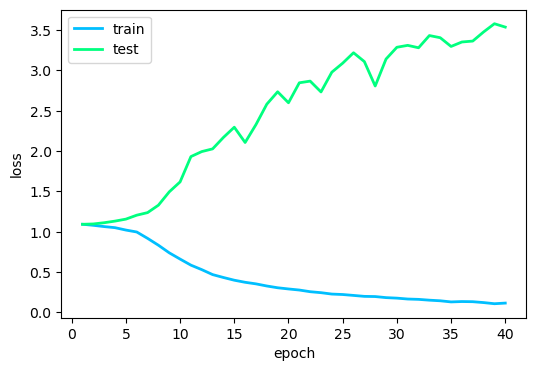

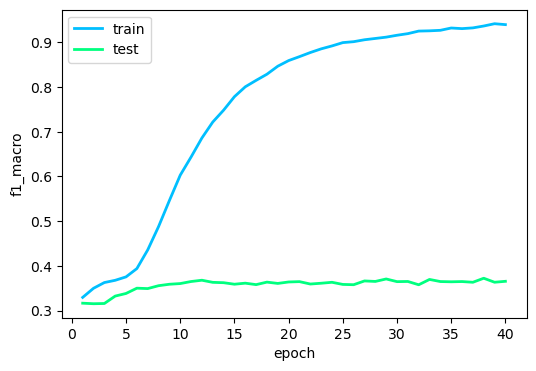

              precision    recall  f1-score   support

           0       0.12      0.08      0.09       997
           1       0.91      0.93      0.92     19138
           2       0.09      0.08      0.08       996

    accuracy                           0.85     21131
   macro avg       0.37      0.36      0.37     21131
weighted avg       0.84      0.85      0.84     21131

CPU times: total: 8min 13s
Wall time: 19min 21s


In [46]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=val_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)